In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os, json, math, torch, tqdm
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
import os
import itertools

import torch
import numpy as np

import transformers
from transformers import AutoModel, AutoProcessor, CLIPForImageClassification, AutoConfig, AutoTokenizer
from torchvision import transforms
from torchvision.datasets import ImageNet
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 – 3D 기능 활성화
import inspect
import torch.nn.functional as F
import torchvision.transforms.functional as VF
import tqdm


from functools import partial

from torchvision import transforms
from torchvision.transforms import InterpolationMode

from tqdm import tqdm

import yaml
from pathlib import Path

import sys
import os

from imagenet_classes import *


In [3]:
from typing import Sequence, Tuple, Literal, Optional, List, Dict, Mapping, Any
import pandas as pd
import matplotlib.pyplot as plt
import torch

def grid_visualize(tensor: torch.Tensor,
                   grid_shape: tuple,
                   topk: int,
                   title: str | None = None,
                   ax: plt.Axes | None = None):
    """
    tensor     : 1‑D (torch.Tensor) – 총 원소 수 = np.prod(grid_shape)
    grid_shape : (rows, cols)
    topk       : 상위 k개 값 표시
    title      : 그리드 제목
    ax         : subplot 축. None이면 새 figure 생성
    """
    created_fig = None
    if ax is None:
        created_fig, ax = plt.subplots(figsize=(5, 5))

    grid = tensor.reshape(grid_shape)
    im = ax.imshow(grid, cmap='viridis', origin='upper')

    # top‑k 위치 찾기
    flat_idx = np.argpartition(grid.ravel(), -topk)[-topk:]
    # np.argpartition을 쓰면 O(N)이라고 하네요
    rows, cols = np.unravel_index(flat_idx, grid.shape)

    for r, c, idx in zip(rows, cols, flat_idx):
        val = grid[r, c]
        ax.annotate(
            f"{idx}\n{val:.2f}",
            xy=(c, r),
            xytext=(c + 0.6, r + 0.6),
            arrowprops=dict(arrowstyle="->", color="red", lw=1),
            fontsize=7, color="red", ha='left', va='bottom'
        )

    ax.set_title(title if title else "Grid Visualization", fontsize=12)
    # colorbar는 전체 figure를 알 필요가 있으므로 fig를 받아와야 한다
    fig = created_fig if created_fig else ax.figure
    fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)

    # 반환해서 상위 함수(랩퍼)에서 필요하면 사용하도록
    return fig, ax


def elem_head_analysis(values: torch.Tensor,
                       k: int = 10,
                       bins: int = 30,
                       ax: plt.Axes | None = None,
                       show_console: bool = True):
    """
    values : (N,) 1‑D tensor
    k      : top‑k
    bins   : histogram bins
    ax     : subplot 축
    """
    created_fig = None
    if ax is None:
        created_fig, ax = plt.subplots(figsize=(5, 3))

    # top‑k 추출
    top_vals, top_idx = torch.topk(values, k=k, largest=True, sorted=True)
    top_vals_np = top_vals.cpu().numpy()
    top_idx_np = (top_idx.cpu().numpy()).astype(int)

    # 히스토그램
    ax.hist(values.cpu().numpy(), bins=bins, alpha=0.7, label="All values")

    # top‑k 강조
    ax.scatter(top_vals_np, np.zeros_like(top_vals_np), c="red",
               marker="x", s=60, label=f"Top-{k} values")
    for idx, val in zip(top_idx_np, top_vals_np):
        ax.axvline(val, color="red", linestyle="--", linewidth=0.8, alpha=0.5)
        ax.text(val + 0.02, 0.02,
                f"{idx}:{val:.2f}",
                rotation=45,
                va="bottom", ha="center",
                fontsize=8, color="blue")

    ax.set_title(f"Value distribution (k={k})")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(loc="upper right")

    # 콘솔 출력
    if show_console:
        df = pd.DataFrame({"index": top_idx_np, "value": top_vals_np})
        print("\nTop‑k indices & values")
        print(df.to_string(index=False))

    return created_fig if created_fig else ax.figure, ax

def side_by_side_grid_and_hist(
    tensor: torch.Tensor | Dict[str, torch.Tensor],
    grid_shape: Tuple[int, int],
    topk: int = 10,
    bins: int = 30,
    suptitle: str | None = None,
    save_path: str | None = None,
):
    """
    tensor:
        • 1‑D (T,)  or 2‑D (L, T)
        • OR dict {str: 1‑D (T,)}  ➜ keys가 row 제목
    grid_shape : (rows, cols)  (rows*cols == T)
    """
    # ---------- dict 입력 처리 -----------------------------------
    if isinstance(tensor, dict):
        row_titles = list(tensor.keys())
        tensor = torch.stack([tensor[k] for k in row_titles], dim=0)  # (L, T)
    else:
        row_titles = None

    # ---------- 텐서 차원 보정 -----------------------------------
    if tensor.ndim == 1:
        tensor = tensor.unsqueeze(0)          # (1, T)
    if tensor.ndim != 2:
        raise ValueError("tensor must be 1‑D, 2‑D, or dict[str, 1‑D].")
    L, T = tensor.shape

    if np.prod(grid_shape) != T:
        raise ValueError(f"grid_shape {grid_shape}와 텐서 길이 {T}가 맞지 않습니다.")

    # ---------- Figure ------------------------------------------
    fig, axes = plt.subplots(
        L, 2,
        figsize=(12, 5 * L),
        squeeze=False,
        width_ratios=[1.2, 1.0],
        sharex=False, sharey=False
    )

    # ---------- 각 row 그리기 ------------------------------------
    for l in range(L):
        title = row_titles[l] if row_titles else f"Row {l}"
        grid_visualize(
            tensor[l],
            grid_shape=grid_shape,
            topk=topk,
            title=title,
            ax=axes[l, 0]
        )
        elem_head_analysis(
            tensor[l],
            k=topk,
            bins=bins,
            ax=axes[l, 1],
            show_console=False
        )

    # ---------- 전체 제목 / 저장 ---------------------------------
    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=14)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

In [4]:
# 문제의 원인이 text encoder가 고장이 나 있었다..
device = "cuda:7"
model_path = "/workspace/code/clipL336_TTR"

exp_cfg = AutoConfig.from_pretrained("/workspace/code/clipL336_TTR", trust_remote_code=True)
exp_cfg.pretrained_path = model_path 
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, local_files_only=True)
model = AutoModel.from_pretrained(pretrained_model_name_or_path=model_path, config=exp_cfg, trust_remote_code=True, local_files_only=True)
# 여기 load 되었는 지 확인할 필요 있음
model = model.to(device)
preprocessor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, local_files_only=True)
# tokenizer랑 preprocessor 가져오기

clip_transform = lambda image: preprocessor.image_processor(image, return_tensors="pt")['pixel_values'].squeeze(0)  # 와 이렇게 활용할 방법은 생각도 못했네
model_clip = AutoModel.from_pretrained("openai/clip-vit-large-patch14-336").to(device).half()

Pretrained path from config: /workspace/code/clipL336_TTR
✓ Added '/workspace/code/clipL336_TTR' to Python path.
✓ Successfully imported 'model' from '/workspace/code/clipL336_TTR'
Building vision tower with config: CLIPVisionCfg(layers=24, width=1024, head_width=64, mlp_ratio=4.0, patch_size=14, image_size=336, ls_init_value=None, patch_dropout=0.0, input_patchnorm=False, global_average_pool=False, attentional_pool=False, n_queries=256, attn_pooler_heads=8, output_tokens=False, timm_model_name=None, timm_model_pretrained=False, timm_pool='avg', timm_proj='linear', timm_proj_bias=False, timm_drop=0.0, timm_drop_path=None)
Currently text tower is removed, using only image encoder for feature extraction
✓ Added '/workspace/data/cache/huggingface/modules/transformers_modules/clipL336_TTR' to Python path.
✓ Successfully imported 'tokenizer' from '/workspace/data/cache/huggingface/modules/transformers_modules/clipL336_TTR'
Custom CLIP model loaded successfully!


In [5]:
model.model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin")), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['positional_embedding', 'text_projection', 'input_resolution', 'context_length', 'vocab_size', 'transformer.resblocks.0.attn.in_proj_weight', 'transformer.resblocks.0.attn.in_proj_bias', 'transformer.resblocks.0.attn.out_proj.weight', 'transformer.resblocks.0.attn.out_proj.bias', 'transformer.resblocks.0.ln_1.weight', 'transformer.resblocks.0.ln_1.bias', 'transformer.resblocks.0.mlp.c_fc.weight', 'transformer.resblocks.0.mlp.c_fc.bias', 'transformer.resblocks.0.mlp.c_proj.weight', 'transformer.resblocks.0.mlp.c_proj.bias', 'transformer.resblocks.0.ln_2.weight', 'transformer.resblocks.0.ln_2.bias', 'transformer.resblocks.1.attn.in_proj_weight', 'transformer.resblocks.1.attn.in_proj_bias', 'transformer.resblocks.1.attn.out_proj.weight', 'transformer.resblocks.1.attn.out_proj.bias', 'transformer.resblocks.1.ln_1.weight', 'transformer.resblocks.1.ln_1.bias', 'transformer.resblocks.1.mlp.c_fc.weight', 'transformer.resblocks.1.mlp.c_fc.bias

In [6]:
# langauge head
### zeroshot head construction (text encoding) ###
construction_language_cls_head = True

if construction_language_cls_head:
    with torch.no_grad():
        zeroshot_weight = []
        for classname in tqdm(IMAGENET_CLASSNAMES):
            texts = [template(classname) for template in OPENAI_IMAGENET_TEMPLATES]
            text_inputs = preprocessor(text=texts, return_tensors="pt", padding="max_length").to(device)
            # text_inputs = model.tokenize(texts).to(device)
            # text_features = model.encode_text(text_inputs.input_ids)
            text_features = model_clip.get_text_features(**text_inputs)
            text_feature = F.normalize(text_features, dim=-1).mean(dim=0)
            # text_feature = text_features.mean(dim=0)
            text_feature = text_feature / text_feature.norm()
            zeroshot_weight.append(text_feature)
        
        text_features = torch.stack(zeroshot_weight, dim=1).to(device)
    print("Built text features:", text_features.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:24<00:00, 41.62it/s]

Built text features: torch.Size([768, 1000])


In [7]:
imagenet_dataset = ImageNet(root='/workspace/data/imagenet', split='val', transform=clip_transform)
eval_loader = torch.utils.data.DataLoader(imagenet_dataset, batch_size=128, num_workers=16, pin_memory=False, shuffle=False)

In [8]:
import numpy as np

half = "torch.bfloat16"
def evaluate(model, loader, text_feats, max_samples: int | None = None):
    model.eval()
    top1 = top5 = n = 0
    pbar = tqdm(loader, desc="Evaluating", unit="batch")
    with torch.no_grad():
        for images, labels in pbar:
            if max_samples and n >= max_samples:
                break
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.autocast(device_type="cuda"):
                # 여기 test-time 가공 함수 구현 필요
                feats = model.encode_image(images)

                feats = feats / feats.norm(dim=-1, keepdim=True)
                logits = model.model.logit_scale.exp() * feats @ text_feats 
            _, pred = logits.topk(5, dim=-1)
            top1 += (pred[:, :1] == labels.unsqueeze(1)).sum().item()
            top5 += (pred == labels.unsqueeze(1)).sum().item()
            n += images.size(0)
            pbar.set_postfix(samples=n, top1=top1 / n * 100, top5=top5 / n * 100)
        return top1 / n * 100, top5 / n * 100


In [9]:
weight = torch.load("/workspace/code/temp_weight/pytorch_model_fromJit.bin")
model.model.load_state_dict(weight, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['positional_embedding', 'text_projection', 'input_resolution', 'context_length', 'vocab_size', 'transformer.resblocks.0.attn.in_proj_weight', 'transformer.resblocks.0.attn.in_proj_bias', 'transformer.resblocks.0.attn.out_proj.weight', 'transformer.resblocks.0.attn.out_proj.bias', 'transformer.resblocks.0.ln_1.weight', 'transformer.resblocks.0.ln_1.bias', 'transformer.resblocks.0.mlp.c_fc.weight', 'transformer.resblocks.0.mlp.c_fc.bias', 'transformer.resblocks.0.mlp.c_proj.weight', 'transformer.resblocks.0.mlp.c_proj.bias', 'transformer.resblocks.0.ln_2.weight', 'transformer.resblocks.0.ln_2.bias', 'transformer.resblocks.1.attn.in_proj_weight', 'transformer.resblocks.1.attn.in_proj_bias', 'transformer.resblocks.1.attn.out_proj.weight', 'transformer.resblocks.1.attn.out_proj.bias', 'transformer.resblocks.1.ln_1.weight', 'transformer.resblocks.1.ln_1.bias', 'transformer.resblocks.1.mlp.c_fc.weight', 'transformer.resblocks.1.mlp.c_fc.bias

In [10]:
model = model.half().to(device)

In [11]:
sample_image = imagenet_dataset[0][0].unsqueeze(0).half().to(device)
result = model.encode_image(sample_image, get_hidden_states=True)  # test
# 이거 그대로 이제 foward
# 알고리즘 차이인가

In [12]:
result["hidden_states"][-1].shape  # (1, 197, 768)

torch.Size([1, 578, 1024])

In [13]:
consecutive_layer_patches = []
consecutive_layer_registers = []


for elem in result["hidden_states"]:
    consecutive_layer_patches.append(elem[:, 1:-1].detach().cpu())  # CLS 제외
    consecutive_layer_registers.append(elem[:, 0].detach().cpu())  # CLS 제외

In [14]:
register_norms = torch.cat(consecutive_layer_registers[1:], dim=0)
register_norms.norm(dim=-1)
# 잘못된 activation의 값을 높히고 있다.
# 알고리즘이 다르게 동작하고 있다. 아무래도 neruron의 위치를 잘못 잡는 것으로 보인다.
# 등가 weight에서 아무래도 neuron의 위치를 잘못 잡아서 생기는 문제로 보인다.

tensor([13.4766, 12.7812, 12.9453, 12.8281, 12.3984, 12.4062, 11.7422, 11.6953,
        11.2812, 10.4688,  8.9219,  7.6602,  6.6641,  6.2266,  6.3359,  6.1289,
         6.9727,  7.6289,  9.1016, 11.1875, 12.0625, 12.6641, 14.7344, 13.5547],
       dtype=torch.float16)

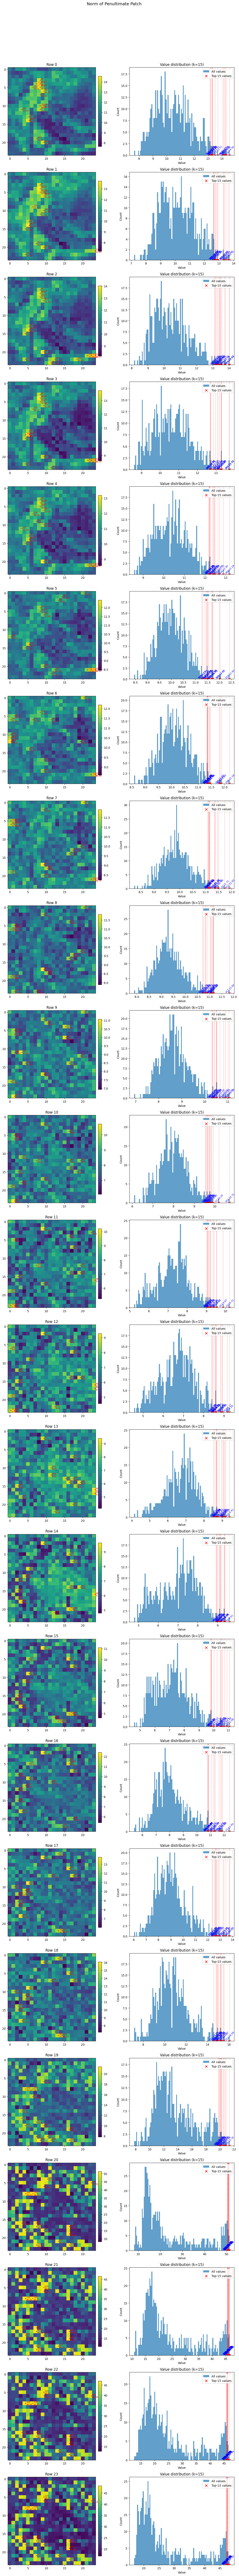

In [15]:
layer_wise_act_raw = torch.cat(consecutive_layer_patches[1:], dim=0)
layer_wise_act = layer_wise_act_raw.detach().cpu().float()
layer_wise_act_norm = layer_wise_act.norm(dim=-1, p=2) 
# layer_wise_act_norm = layer_wise_act[:,:,650][:, 1:] 
patch_size = 24
side_by_side_grid_and_hist(layer_wise_act_norm,
                           grid_shape=(patch_size, patch_size), 
    topk=15,
    bins=100,
    suptitle="Norm of Penultimate Patch",
)

In [16]:
raise StopIteration()

StopIteration: 

In [ ]:

### baseline evaluator ###
### 이거는 지금 당장은 못 써먹는다... 미친 너무 느리다 어디서 문제지 ###
# 씨발 이번에 뭐지
# architecture define이 어딘가에서 손상 된 것으로 보인다
# 성능 reproduce...

BASELINE_SAMPLES = 50000  # set to None for full 50 k
acc1, acc5 = evaluate(model, eval_loader, text_features, max_samples=BASELINE_SAMPLES)
print(f"Baseline (Top‑1 / Top‑5) on {BASELINE_SAMPLES or len(imagenet_dataset):,} imgs: {acc1:.2f}% / {acc5:.2f}%")

Evaluating:   2%|▏         | 6/391 [00:13<14:35,  2.27s/batch, samples=768, top1=89.1, top5=98.3]


KeyboardInterrupt: 